In [23]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [29]:
# Fonction pour prétraiter les données historiques
def preprocess_true_data(df):
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - new_df["date"].min()).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [31]:
# Fonction pour prétraiter les données générées synthétiquement
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [33]:
# Fonction pour préparer les données sous forme de fenêtres temporelles pour Conv1D
# window_size : nombre de données utilisé pour la prédiction
# window_step : pas entre les fenêtres
# horizon : combien de pas on veut prédire dans le future
def get_x_y_window_conv1d(df, y_key: str, window_size: int, window_step: int, horizon: int):
    X, y = [], []
    for i in range(0, len(df) - window_size - horizon, window_step):
        X.append(df[["dayofweek", "hourofday", "dayofseries"]].iloc[i:i+window_size].values)
        y.append(df[y_key].iloc[i+window_size:i+window_size+horizon].values)
    X = np.array(X)
    y = np.array(y)
    return X, y

## Modèle

In [34]:
# Fonction pour créer le modèle Conv1D
def create_conv1d_model(input_shape, horizon):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(horizon))  # La sortie est de dimension `horizon` pour la prévision à plusieurs pas
    model.compile(optimizer='adam', loss='mse')
    return model

In [50]:
# Fonction pour afficher les prédictions par rapport aux valeurs réelles
def plot_predictions_vs_real_window(X_test, y_test, predictions):
    plt.figure(figsize=(15,5))
    y_true = np.concatenate([X_test[0], y_test[0]])
    x_true = np.arange(0, len(y_true))
    y_preds = predictions[0]
    x_preds = np.arange(len(X_test[0]), len(X_test[0])+len(y_preds))
    plt.scatter(x_true, y_true, color='r', label="True")
    plt.scatter(x_preds, predictions, color='b', label="Prediction")
    plt.title('Real vs predicted prices depending on time')
    plt.xlabel('Time (h)')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

In [38]:
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")

# Prétraiter les données historiques
df_price_preprocessed = preprocess_true_data(df_price)
df_price_generated_11113_preprocessed = preprocess_synthetic_data(df_price_generated_11113)

In [39]:
# Test données historiques

df = preprocess_true_data(df_price)
df.head(10)

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,0,0
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,0,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,0,2
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,0,3
5,2017-01-01 04:00:00+00:00,44.50,6,4,1,0,4
6,2017-01-01 05:00:00+00:00,44.50,6,5,1,0,5
7,2017-01-01 06:00:00+00:00,44.72,6,6,1,0,6
8,2017-01-01 07:00:00+00:00,44.22,6,7,1,0,7
9,2017-01-01 08:00:00+00:00,42.06,6,8,1,0,8


In [40]:
# Test donnée synthétic

df = preprocess_synthetic_data(df_price_generated_11113)
df.head(10)

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4
5,23.57,0,5,0,5
6,27.09,0,6,0,6
7,29.01,0,7,0,7
8,26.22,0,8,0,8
9,26.37,0,9,0,9


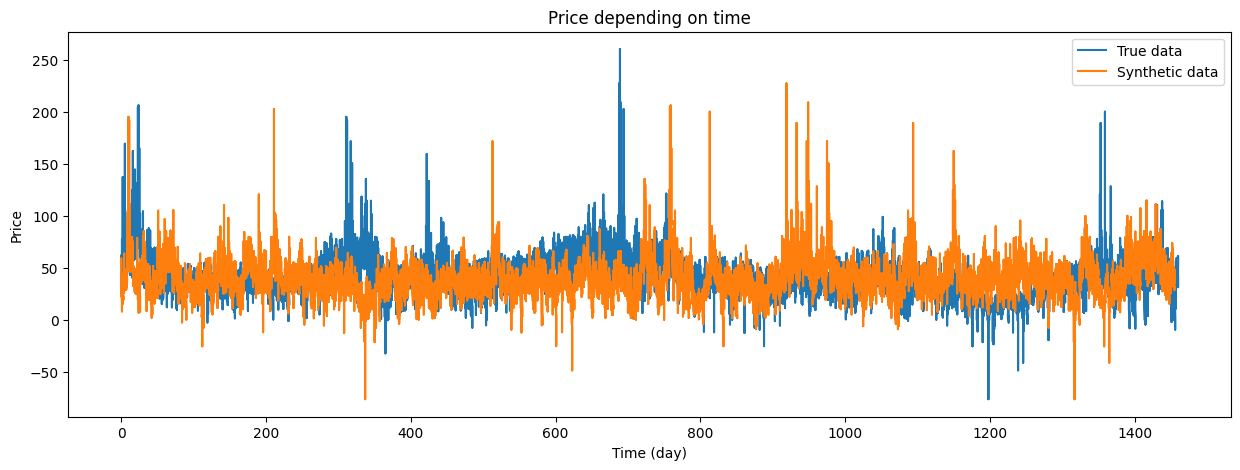

In [41]:
# données réelles vs synthétiques

plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["dayofseries"], df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_11113_preprocessed["dayofseries"], df_price_generated_11113_preprocessed["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [42]:
# Charger les données de scénario synthétique
def load_synthetic_data_window(path):
    X_train_all, y_train_all = [], []
    for filename in tqdm(os.listdir(path)):
        if filename.endswith(".parquet"):
            df = pd.read_parquet(path + filename)
            df_preprocessed = preprocess_synthetic_data(df)
            X_train, y_train = get_x_y_window_conv1d(df_preprocessed, "price", window_size=24, window_step=12, horizon=12)
            X_train_all.extend(X_train)
            y_train_all.extend(y_train)
    return np.array(X_train_all), np.array(y_train_all)

In [43]:
# Charger les données synthétiques
directory = "../data/CYTECH/scenarios synthetiques/prix/"
X_train_synthetic, y_train_synthetic = load_synthetic_data_window(directory)

100%|██████████| 154/154 [13:16<00:00,  5.17s/it]


In [44]:
# Préparer les données d'entraînement et de test pour le modèle Conv1D
window_size = 24  # Par exemple, 24 heures de données pour prédire les prix à venir
window_step = 12  # La fenêtre se déplace de 12 heures à chaque fois
horizon = 12  # Prévision sur 12 heures
X, y = get_x_y_window_conv1d(df_price_preprocessed, 'price', window_size, window_step, horizon)

# Séparer les données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Créer et entraîner le modèle Conv1D
model = create_conv1d_model(X_train.shape[1:], horizon)
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Prédictions et évaluation
predictions = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, predictions))

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2143.1484 - val_loss: 483.1817
Epoch 2/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 358.5487 - val_loss: 560.1172
Epoch 3/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 295.1312 - val_loss: 296.5782
Epoch 4/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 291.6516 - val_loss: 302.3075
Epoch 5/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 246.4441 - val_loss: 303.8452
Epoch 6/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 226.6816 - val_loss: 454.7098
Epoch 7/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 253.6339 - val_loss: 306.4187
Epoch 8/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 245.4930 - val_loss: 395.9207
Epoch 9/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 208.3464 - val_loss: 332.9185
Epoch 10/10
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 199.7532 - val_loss: 381.2852
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE: 381.28516519561964


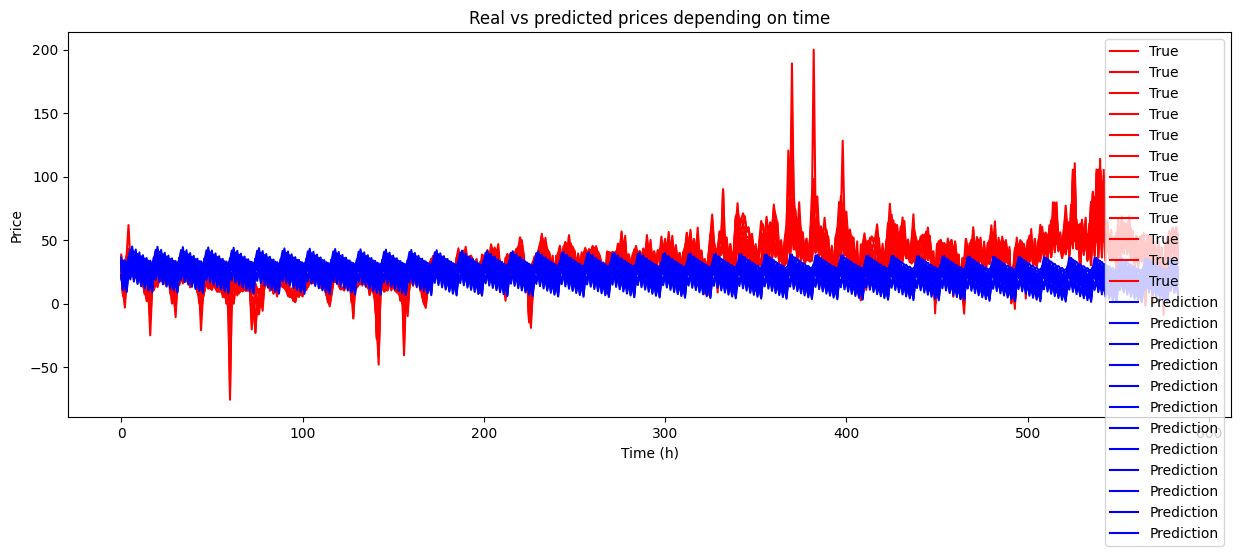

In [49]:
# Affichage des résultats
plot_predictions_vs_real_window(X_test, y_test, predictions)

# -----------------  Test 2  -------------------------

In [76]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from typing import List
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [ ]:
# Charger et prétraiter les données historiques
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()

# Charger et prétraiter les données synthétiques
df_price_generated = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")

In [77]:
def preprocess_true_data(df):
    # df['date'] = pd.to_datetime(df['date'])
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - new_df["date"].min()).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    
    return new_df

In [86]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head(10)

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,0,0
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,0,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,0,2
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,0,3
5,2017-01-01 04:00:00+00:00,44.50,6,4,1,0,4
6,2017-01-01 05:00:00+00:00,44.50,6,5,1,0,5
7,2017-01-01 06:00:00+00:00,44.72,6,6,1,0,6
8,2017-01-01 07:00:00+00:00,44.22,6,7,1,0,7
9,2017-01-01 08:00:00+00:00,42.06,6,8,1,0,8


In [78]:
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [87]:
df_price_generated_preprocessed = preprocess_synthetic_data(df_price_generated)
df_price_generated_preprocessed.head(10)

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4
5,23.57,0,5,0,5
6,27.09,0,6,0,6
7,29.01,0,7,0,7
8,26.22,0,8,0,8
9,26.37,0,9,0,9


In [88]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

In [89]:
def get_x_y_point_by_point(df, x_keys: List[str], y_key: str):
    X = df[x_keys]
    y = df[y_key]
    return X, y

In [95]:
def create_conv1d_model(input_shape, horizon):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape))  # kernel_size=2
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(horizon))
    model.compile(optimizer='adam', loss='mse')
    return model

In [96]:
# Fonction pour afficher les prédictions et valeurs réelles
def plot_predictions_vs_real(real, predicted):
    plt.figure(figsize=(15, 5))
    plt.plot(real, label='Réel', color='red')
    plt.plot(predicted, label='Prédiction', color='blue')
    plt.title('Comparaison des prédictions et des valeurs réelles')
    plt.xlabel('Temps (heures)')
    plt.ylabel('Prix')
    plt.legend()
    plt.show()

In [107]:
horizon = 24 

train_data, test_data = split_data(df_price_preprocessed, 24)
X_train, y_train = get_x_y_point_by_point(train_data, ["dayofweek", "hourofday", "dayofseries"], "price")
X_test, y_test = get_x_y_point_by_point(test_data, ["dayofweek", "hourofday", "dayofseries"], "price")

# # Redimensionner X_train et X_test pour qu'ils aient la forme (samples, timesteps, features)
# X_train = np.array(X_train).reshape((X_train.shape[0], 1, X_train.shape[1]))  # 1 timestep par sample
# X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))  # 1 timestep par sample

In [108]:
print(y_train)

0        58.82
1        58.23
2        51.95
3        47.27
4        45.49
         ...  
35035    59.86
35036    56.50
35037    52.95
35038    51.13
35039    47.64
Name: price, Length: 35040, dtype: float64


In [99]:
# Créer le modèle
model = create_conv1d_model(input_shape=(X_train.shape[1], X_train.shape[2]), horizon=horizon)

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=20, batch_size=32)

Epoch 1/20


c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1095/1095 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 871.7347
Epoch 2/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 459.2868
Epoch 3/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 336.7235
Epoch 4/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 298.5859
Epoch 5/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 278.4537
Epoch 6/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 262.8943
Epoch 7/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 256.2496
Epoch 8/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 246.7467
Epoch 9/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 246.0241
Epoch 10/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 232.7549
Epoch 11/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 236.2552
Epoch 12/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 225.1200
Epoch 13/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 233.7325
Epoch 14/20
1095/1095 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 223.7811
Epoch 15/20


In [114]:
# Faire des prédictions sur le jeu de test
predictions = model.predict(X_test)

print(predictions)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=int64)
  • training=False
  • mask=None

In [100]:


# Calculer l'erreur quadratique moyenne (MSE)
mse = mean_squared_error(y_test, predictions)
print("MSE (Test sur les données historiques) :", mse)

# Afficher les prédictions contre les valeurs réelles
plot_predictions_vs_real(y_test, predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


ValueError: y_true and y_pred have different number of output (1!=24)

In [ ]:
# Modèle entraîné sur les données historiques
model = create_conv1d_model(X.shape[1:], horizon)
model.fit(X, y, epochs=10, batch_size=1, verbose=1)

# Prédictions et évaluation
predictions = model.predict(X)
mse = mean_squared_error(y[0], predictions[0])
print("MSE (Données historiques) :", mse)

# Afficher les prédictions
plot_predictions_vs_real(y[0], predictions[0])

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - loss: 24141.5332
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 2533327616.0000
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 284872448.0000
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 92959880.0000
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 16577467.0000
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 26478122.0000
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 206693.4531
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1269.6132
Epoch 9/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1269.6193
Epoch 10/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1269.6249
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
MSE (Données synthétiques) : 1269.629645768677


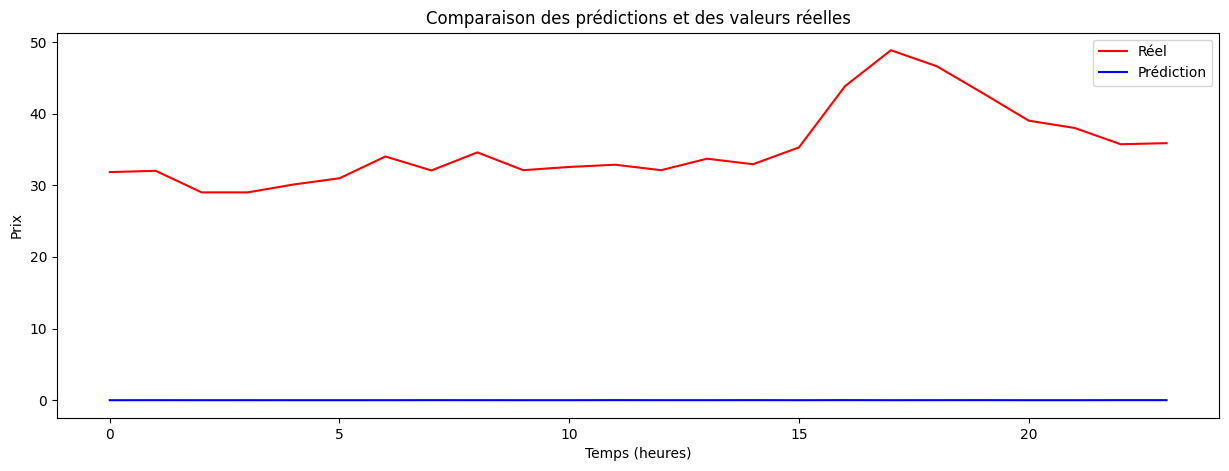

In [59]:
# Données synthétiques : préparer une seule fenêtre pour tout l'historique synthétique
X_synthetic, y_synthetic = get_full_data_window(df_price_generated_preprocessed, 'price', horizon)

# Modèle entraîné sur les données synthétiques
model_synthetic = create_conv1d_model(X_synthetic.shape[1:], horizon)
model_synthetic.fit(X_synthetic, y_synthetic, epochs=10, batch_size=1, verbose=1)

# Prédictions et évaluation
predictions_synthetic = model_synthetic.predict(X_synthetic)
mse_synthetic = mean_squared_error(y_synthetic[0], predictions_synthetic[0])
print("MSE (Données synthétiques) :", mse_synthetic)

# Afficher les prédictions
plot_predictions_vs_real(y_synthetic[0], predictions_synthetic[0])


# ----------- Test 3 ----------

In [116]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from typing import List
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

In [117]:
# Charger et prétraiter les données historiques
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()

# Charger et prétraiter les données synthétiques
df_price_generated = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")

In [119]:
def preprocess_true_data(df):
    # df['date'] = pd.to_datetime(df['date'])
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - new_df["date"].min()).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]

    return new_df

In [136]:
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.head(10)

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,0,0
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,0,1
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,0,2
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,0,3
5,2017-01-01 04:00:00+00:00,44.50,6,4,1,0,4
6,2017-01-01 05:00:00+00:00,44.50,6,5,1,0,5
7,2017-01-01 06:00:00+00:00,44.72,6,6,1,0,6
8,2017-01-01 07:00:00+00:00,44.22,6,7,1,0,7
9,2017-01-01 08:00:00+00:00,42.06,6,8,1,0,8


In [121]:
def preprocess_synthetic_data(df):
    new_df = df.copy()
    new_df['dayofseries'] = 0
    
    day = -1
    for i in range(0, len(new_df)):
        if i % 24 == 0:
            day += 1
        new_df.loc[i, 'dayofseries'] = day
    
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [135]:
df_price_generated_preprocessed = preprocess_synthetic_data(df_price_generated)
df_price_generated_preprocessed.head(10)

,price,dayofweek,hourofday,dayofseries,hoursofseries
0,31.66,0,0,0,0
1,31.06,0,1,0,1
2,27.81,0,2,0,2
3,27.54,0,3,0,3
4,25.04,0,4,0,4
5,23.57,0,5,0,5
6,27.09,0,6,0,6
7,29.01,0,7,0,7
8,26.22,0,8,0,8
9,26.37,0,9,0,9


In [144]:
def get_x_y_point_by_point(data, features, target, horizon):
    X, y = [], []
    for i in range(len(data) - horizon):
        # Caractéristiques pour un jour donné
        X.append(data[features].iloc[i].values)
        
        # Cible : Les 24 prochaines heures
        y.append(data[target].iloc[i+1:i+1+horizon].values)  # 24 valeurs suivantes
        
    return np.array(X), np.array(y)

In [145]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

In [146]:
# Exemple de préparation des données
horizon = 24  # Prédire les 24 prochaines heures
train_data, test_data = split_data(df_price_preprocessed, horizon)          # Récupérer les 24h à prédire

In [147]:
X_train, y_train = get_x_y_point_by_point(train_data, ["dayofweek", "hourofday", "dayofseries"], "price", horizon)
X_test, y_test = get_x_y_point_by_point(test_data, ["dayofweek", "hourofday", "dayofseries"], "price", horizon)

In [134]:
print(X_test)

[]


In [125]:


# Redimensionner X_train et X_test pour qu'ils aient la forme (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # 1 timestep par sample
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # 1 timestep par sample


IndexError: tuple index out of range

# ----------------  Test 4  ----------------------

In [252]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

## Données historiques

In [253]:
# Fonction pour prétraiter les données historiques
def preprocess_true_data(df):
    reference_date = pd.to_datetime("2016-12-31 00:00:00+00:00")
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - reference_date).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [255]:
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.to_csv("test.csv", sep=";")
df_price_preprocessed.head(40)

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,1,24
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,1,25
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,1,26
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,1,27
5,2017-01-01 04:00:00+00:00,44.50,6,4,1,1,28
6,2017-01-01 05:00:00+00:00,44.50,6,5,1,1,29
7,2017-01-01 06:00:00+00:00,44.72,6,6,1,1,30
8,2017-01-01 07:00:00+00:00,44.22,6,7,1,1,31
9,2017-01-01 08:00:00+00:00,42.06,6,8,1,1,32


## Données synthétiques

In [164]:
# # Fonction pour prétraiter les données générées synthétiquement
# def preprocess_synthetic_data(df):
#     new_df = df.copy()
#     new_df['dayofseries'] = 0
#     day = -1
#     for i in range(0, len(new_df)):
#         if i % 24 == 0:
#             day += 1
#         new_df.loc[i, 'dayofseries'] = day
#     new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
#     return new_df

In [165]:
# df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")
# df_price_generated_11113_preprocessed = preprocess_synthetic_data(df_price_generated_11113)

# print(df_price_generated_11113)

In [163]:
# df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")
# df_price_generated_11113_preprocessed = preprocess_synthetic_data(df_price_generated_11113)

# df_price_generated_11113_preprocessed.head(10)

In [256]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

In [257]:
horizon = 100  # Prédire les 100 prochaines heures
train_data, test_data = split_data(df_price_preprocessed, horizon)   

## !!  Vérifier si test et train ne se supperpose pas  !!

In [258]:
import numpy as np

def create_input_output(df, window_size=12):
    X = []
    y = []
    
    # X : les 12 dernières heures (prix), jour de la semaine, heure, jour de l'année, jour de la serie
    for i in range(window_size, len(df)):
        
        x_data = df.iloc[i-window_size:i][['price']].values.flatten()
    
        x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear'], df.iloc[i]['dayofseries']]])
        
        # y : prix de l'électricité à l'heure suivante
        y.append(df.iloc[i]['price'])
        
        X.append(x_data)
    
    return np.array(X), np.array(y)


window_size = 12  # 12 dernières heures pour prédire l'heure suivante
X_train, y_train = create_input_output(train_data, window_size)
X_test, y_test = create_input_output(test_data, window_size)

X_test_first = X_test[0]


print(X_train)
print(y_train)

# Vérifier la forme des données X et y
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


[[ 5.882e+01  5.823e+01  5.195e+01 ...  1.100e+01  1.000e+00  1.000e+00]
 [ 5.823e+01  5.195e+01  4.727e+01 ...  1.200e+01  1.000e+00  1.000e+00]
 [ 5.195e+01  4.727e+01  4.549e+01 ...  1.300e+01  1.000e+00  1.000e+00]
 ...
 [-3.360e+00 -8.000e-02  4.300e+00 ...  1.600e+01  3.620e+02  1.457e+03]
 [-8.000e-02  4.300e+00  9.370e+00 ...  1.700e+01  3.620e+02  1.457e+03]
 [ 4.300e+00  9.370e+00  2.450e+01 ...  1.800e+01  3.620e+02  1.457e+03]]
[49.57 48.69 46.91 ... 42.26 47.7  46.41]
X_train shape: (34952, 16)
y_train shape: (34952,)
X_test shape: (88, 16)
y_test shape: (88,)


In [259]:
print(X_train[-1])
print(y_train[-1])

[   4.3     9.37   24.5    28.12   25.47   27.97   24.46   21.15   20.57
   22.8    42.26   47.7     6.     18.    362.   1457.  ]
46.41


In [260]:
print(X_test[1])
print(y_test[1])

[  33.5    33.27   23.92   25.6    25.5    20.39   11.24   11.5    20.43
   35.1    45.27   49.23    0.      8.    363.   1458.  ]
52.09


In [261]:
# Fonction pour créer le modèle Conv1D
def create_conv1d_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Prédiction du prix à l'heure suivante
    
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae'])
    return model

In [262]:
# Créer le modèle
input_shape = (X_train.shape[1], 1)  # Ajuster la forme pour Conv1D (timesteps, features)
model = create_conv1d_model(input_shape)

# Afficher le résumé du modèle
model.summary()

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 14, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 896)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │        57,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,729 (225.50 KB)

 Trainable params: 57,729 (225.50 KB)

 Non-trainable params: 0 (0.00 B)

In [263]:
# Reshaper les données pour Conv1D (timesteps, features)
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

print(X_train_reshaped)

# Entraîner le modèle
history = model.fit(
    X_train_reshaped, y_train,
    epochs=10,  # Ajustez le nombre d'époques selon vos besoins
    batch_size=32,
    verbose=1
)

[[[ 5.882e+01]
  [ 5.823e+01]
  [ 5.195e+01]
  ...
  [ 1.100e+01]
  [ 1.000e+00]
  [ 1.000e+00]]

 [[ 5.823e+01]
  [ 5.195e+01]
  [ 4.727e+01]
  ...
  [ 1.200e+01]
  [ 1.000e+00]
  [ 1.000e+00]]

 [[ 5.195e+01]
  [ 4.727e+01]
  [ 4.549e+01]
  ...
  [ 1.300e+01]
  [ 1.000e+00]
  [ 1.000e+00]]

 ...

 [[-3.360e+00]
  [-8.000e-02]
  [ 4.300e+00]
  ...
  [ 1.600e+01]
  [ 3.620e+02]
  [ 1.457e+03]]

 [[-8.000e-02]
  [ 4.300e+00]
  [ 9.370e+00]
  ...
  [ 1.700e+01]
  [ 3.620e+02]
  [ 1.457e+03]]

 [[ 4.300e+00]
  [ 9.370e+00]
  [ 2.450e+01]
  ...
  [ 1.800e+01]
  [ 3.620e+02]
  [ 1.457e+03]]]
Epoch 1/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 47.4344 - mae: 4.5237
Epoch 2/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 25.6119 - mae: 3.3555
Epoch 3/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.0872 - mae: 3.0398
Epoch 4/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 21.4601 - mae: 3.0037
Epoch 5/10
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 20.6326 

In [264]:
print(X_test_first)

[  37.13   33.5    33.27   23.92   25.6    25.5    20.39   11.24   11.5
   20.43   35.1    45.27    0.      7.    363.   1458.  ]


In [265]:
dayofweek = (X_test_first[-4] + 1) % 7
hourofday = (X_test_first[-3] + 1) % 24
dayofyear = (X_test_first[-2] + 1) % 365
dayofseries = X_test_first[-1] + 1

next_price = 10

X_result = np.concatenate([
    X_test_first[1:12],                  # 11 dernières heures
    [next_price, dayofweek, hourofday, dayofyear, dayofseries]  # Prédiction + contexte
])

print(X_result)

[3.350e+01 3.327e+01 2.392e+01 2.560e+01 2.550e+01 2.039e+01 1.124e+01
 1.150e+01 2.043e+01 3.510e+01 4.527e+01 1.000e+01 1.000e+00 8.000e+00
 3.640e+02 1.459e+03]


In [266]:
print(X_result)

[3.350e+01 3.327e+01 2.392e+01 2.560e+01 2.550e+01 2.039e+01 1.124e+01
 1.150e+01 2.043e+01 3.510e+01 4.527e+01 1.000e+01 1.000e+00 8.000e+00
 3.640e+02 1.459e+03]


In [270]:
import numpy as np

def autoregressive_prediction(model, X_test_first, window_size=12):

    predictions = []
    
    for _ in range(window_size):

        X_test_reshape = X_test_first.reshape(1, -1)  # Reshape pour le modèle
        next_price = model.predict(X_test_reshape)[0][0]  # Prédiction de h+1
        predictions.append(next_price)

        print(next_price)

        dayofweek = (X_test_first[-4] + 1) % 7  
        hourofday = (X_test_first[-3] + 1) % 24 
        dayofyear = (X_test_first[-2] + 1) % 365 
        dayofseries = X_test_first[-1] + 1

        X_test_first = np.concatenate([X_test_first[1:12], [next_price, dayofweek, hourofday, dayofyear, dayofseries]])
    
    return predictions

In [275]:
predictions = autoregressive_prediction(model, X_test_first, window_size=99)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
47.751236
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
46.16986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
43.030983
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
42.04736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
39.19563
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
35.558693
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32.750957
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
31.40219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
32.993862
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
37.429863
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
41.665325
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
42.45914
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
40.30433
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
36.95368
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
32.015495
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
27.241346
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
23.412573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
20.308285
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
17.025671
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
14.145753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
12.094373

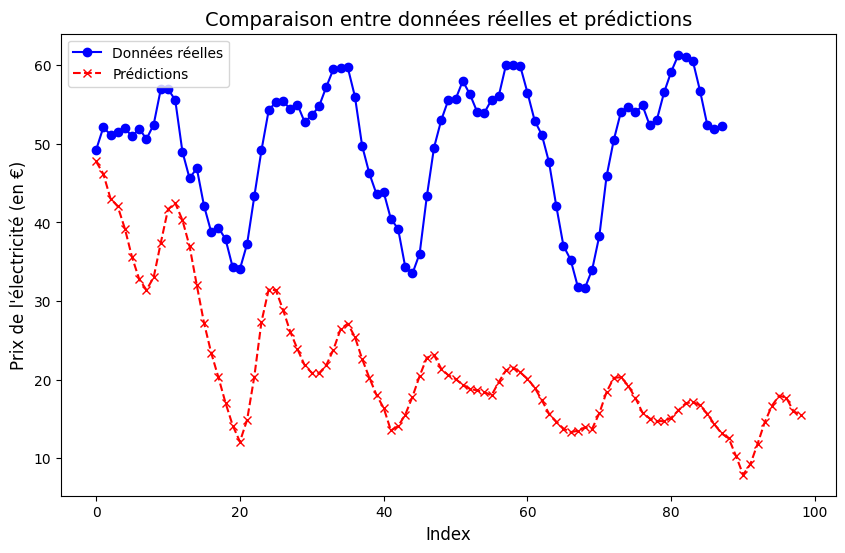

In [276]:
import matplotlib.pyplot as plt

def plot_predictions(true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    

    plt.plot(true_values, label='Données réelles', color='blue', linestyle='-', marker='o')
    plt.plot(predicted_values, label='Prédictions', color='red', linestyle='--', marker='x')
    
    plt.title("Comparaison entre données réelles et prédictions", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Prix de l'électricité (en €)", fontsize=12)
    
    plt.legend(loc='upper left')
    plt.show()

# Exemple d'utilisation avec les prédictions et y_test[0]
plot_predictions(y_test[:99], predictions)


## Évaluer le modèle

In [212]:
test_loss, test_mae = model.evaluate(X_test_reshaped, y_test, verbose=1)
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 5.5906 - mae: 1.8954
Test Loss: 5.5657, Test MAE: 1.8923


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.8816 - mae: 1.3398
Test Loss: 2.8726, Test MAE: 1.3676
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


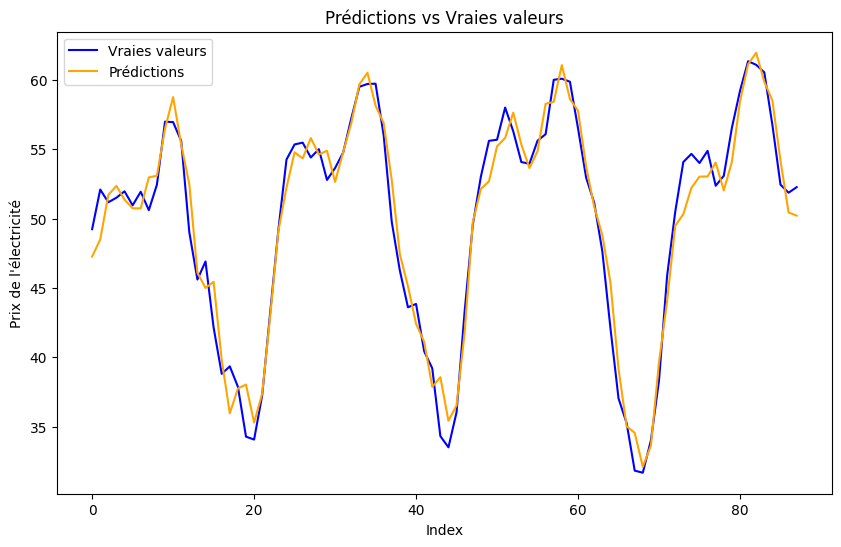

In [187]:
# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_reshaped)

# Visualiser les résultats
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label='Vraies valeurs', color='blue')
plt.plot(range(len(y_pred)), y_pred, label='Prédictions', color='orange')
plt.xlabel('Index')
plt.ylabel('Prix de l\'électricité')
plt.title('Prédictions vs Vraies valeurs')
plt.legend()
plt.show()